import thu vien

In [ ]:
import numpy as np
import argparse
import time
import cv2
import os

from google.colab.patches import cv2_imshow

**Mo ket noi den Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/ThiGiacMayTinh/Yolo3/images

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/ThiGiacMayTinh/Yolo3/images


4. Danh sach nhung nhan va mau sac tuong ung.
**Luu y**: Doc thon tin tu coco.names .Hien tai trong day la 80 nhan

In [ ]:
#Tai cac nhan class COCO cua mo hinh Yolo da duoc huan luyen tren
labelsPath = "../coco.names"
LABELS = open(labelsPath).read().strip().split('\n')
print(LABELS)

#Khoi tao 1 danh sach ban dau de the hien tung nhan co the
np.random.seed(42)      #Hàm seed() dùng để tạo bộ tạo số ngẫu nhiên, hàm này nhận 1 số nguyên đầu vào để thiết lập trạng thái
COLORS = np.random.randint(0 ,255, size=(len(LABELS), 3), dtype='uint8' ) #Tạo 1 mảng ngẫu nhiên trong phạm vi từ 0 đến 255. Kích thước mảng là (len(LABELS), 3). Có nghĩa là mảng len(LABELS) có 3 cột và mỗi phần từ mang kiểu dữ liệu unit8

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


5. Doc mo hinh Yolo3. Bao gom: yolov3.weights, yolov3.cfg
- Tao mang DNN voi thu vien cv2.
- Doc anh de do tim doi tuong.

In [ ]:
#url_img = 'soccer.jpg'
url_img = 'bongro2.jpg'

#chuyen huong den duong dan den Yolo weitghs va mo hinh cau hinh
weightsPath = '../yolov3.weights' #Đây là mô hình Yolo version 3, mô hình này đã được huấn luyện từ trước. Mô hình này chứa các trọng số quan trọng và các tham số tương ứng
configpath =  '../yolov3.cfg'     #tệp định cấu hình quan trọng để xác định kiến trúc và cấu hình của mô hình YOLO, và nó cho phép bạn tùy chỉnh và điều chỉnh mô hình theo nhu cầu

#Tai duoi tuong YOLO de nhan dien da duoc huan luyen tren bo du lieu (80 classes)
print('[INFO] loading YOLO from disk...')
net = cv2.dnn.readNetFromDarknet( configpath, weightsPath)  #Hàm này tải mô hình YOLO từ tệp mô hình và tệp định cấu hình. Hàm trả về một đối tượng mạng nơ-ron có thể được sử dụng để thực hiện dự đoán

#Tai hinh anh dau vao
image = cv2.imread(url_img)
(H,W) = image.shape[:2]

#Chi xac dinh cac ten lop (Dau ra) de  chung can tu YOLO
ln = net.getLayerNames()    # lấy tên của tất cả các lớp trong mô hình YOLO.
ln = [ln[i -1] for i in net.getUnconnectedOutLayers()]


[INFO] loading YOLO from disk...


6. Xay dung va do tim doi tuong

In [ ]:
'''
  - cv2.dnn.blobFromImage(): Chuản bị và tiền xử lý hình ảnh đầu vào để phù hợp với yêu cầu của mạng DNN.
    + cv2.dnn.blobFromImage(): là hàm OpenCV giúp tạo một blob (một đối tượng lưu trữ dữ liệu cho mạng DNN) từ hình ảnh.
    + image: ảnh cần xử lý
    + 1/255: Tỷ lệ chuẩn hóa giá trị pixel về khoảng từ 0 đến 1. Đây là một bước quan trọng để chuẩn hóa dữ liệu
    trước khi đưa vào mạng DNN.
    + (416, 416): Kích thước mong muốn của hình ảnh đầu ra. Hình ảnh sẽ được co giãn hoặc cắt để phù hợp
    với kích thước này.
    + swapRB=True: Hoán đổi kênh màu đỏ và xanh lam (Red, Blue). Một số mạng DNN yêu cầu thứ tự
    kênh màu BGR (Blue, Green, Red) thay vì RGB.
    + crop=False: Không cắt hình ảnh để phù hợp với kích thước mong muốn. Thay vào đó, hình ảnh sẽ được co giãn để phù hợp.
'''
blob = cv2.dnn.blobFromImage( image, 1/255 ,(416,416), swapRB=True, crop=False)
net.setInput(blob)  #Đặt blob đã chuẩn bị làm đầu vào cho mạng DNN.
start = time.time()

'''
  net.forward(ln): Chức năng: Chạy quá trình suy luận của mạng DNN và lấy các kết quả đầu ra từ một hoặc nhiều lớp cụ thể.
    + net.forward là phương thức của đối tượng mạng DNN để chạy suy luận.
    + ln là tên hoặc chỉ số của lớp hoặc các lớp cần lấy kết quả đầu ra.
'''
layerOutputs = net.forward(ln)

end = time.time()

#Hien thi thong tin thoi gian chay tren YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 3.164309 seconds


7. Loc ket qua do tim
LayerOutputs bao gom: [..., fram anh, khong do tim thay,[classid, score, confidence, x,y,h,w]]

In [ ]:
#Dat nguon de do tim va bo vao box
boxes = []
confidences = []
classIDs = []
Find_confidence = 0.5
Find_threshold = 0.3

#Lặp qua từng đầu ra của lớp
for output in layerOutputs:
  #Lặp từng phát hiện
  for detection in output:
    #trích xuất ID và độ tin cậy( tức xác suất) của việc phát hiện đối tượng hiện tại
    scores = detection[5:]

    classID = np.argmax(scores)
    confidence = scores[classID]

    #Lọc ra các dự đoán yếu bằng cách đảm bảo xác suất được phát hiện lớn hơn xác xuất tối thiểu
    if confidence > Find_confidence:
      box = detection[0:4] * np.array([W, H, W, H])
      (centerX, centerY, width, height) = box.astype('int')

      # Sự dụng trung tâm toạn độ (x,y) để suy ra góc trên và trái của hộp giới hạn
      x = int(centerX - (width/2))
      y = int(centerY - (height/2) )

      #Cập nhật  danh sách của các tọa độ hộp giới hạn, confidences and ClassIDs
      boxes.append([x, y, int(width), int(height)])
      confidences.append(float(confidence))
      classIDs.append(classID)


8. Xac dinh dua tren nguong Threshold

In [ ]:
#Áp dụng mức triệt tiêu không tối đa để ngăn chặn các hộp giới hạn yếu chồng chéo lên nhau
idxs = cv2.dnn.NMSBoxes(boxes, confidences, Find_confidence, Find_threshold)
print(idxs)

[ 5  8  2 16 13 18 17]


9. Ve hinh chu nhat va phan tram len anh

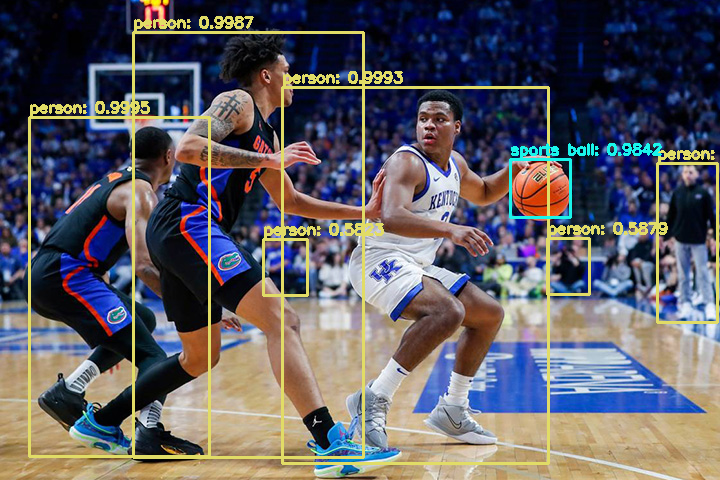

In [ ]:
#Đảm bảo rằng ít nhất 1 phát hiện tồn tại
if len(idxs) > 0:
  #Lạp các chỉ mục chúng tôi đang giữ
  for i in idxs.flatten():
    #trích xuất tọa dộ hộp giới hạn
    (x,y) = (boxes[i][0], boxes[i][1])
    (w, h) = (boxes[i][2], boxes[i][3])

    #Vẽ 1 hình chữ nhật cho hộp giới hạn và gán nhãn
    color = [int(c) for c in COLORS[classIDs[i]]]
    cv2.rectangle(image, (x,y), (x+w, y+h), color, 2)
    text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
    cv2.putText(image, text, (x,y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    anhcuoi = image

  cv2_imshow( anhcuoi)




#----------------------------------------------------------------------------------------------




In [ ]:
print(__Yolo__)